### Reconstruct a subset of the Upgrade test events

In [1]:
import pickle
import math
import time
from multiprocessing import Process, Pool
from copy import deepcopy
from functools import partial

from matplotlib import pyplot as plt
import numpy as np
import zmq

from freedom.llh_service.llh_client import LLHClient
from freedom.reco import crs_reco
from freedom.reco import summary_df
from freedom.reco import transforms

In [2]:
params = {'legend.fontsize': 17,
          'figure.figsize': (15, 9.3),
          'axes.labelsize': 20,
          'axes.titlesize': 20,
          'xtick.labelsize': 22,
          'ytick.labelsize': 22}
plt.rcParams.update(params)

In [3]:
cvmfs_path = '/cvmfs/icecube.opensciencegrid.org/users/peller/freeDOM/resources'
model_path = f'{cvmfs_path}/Upgrade_NNs'

In [4]:
n_gpus = 4

In [5]:
n_live_points = 97

In [6]:
n_events = 400

In [7]:
with open(f'{cvmfs_path}/test_events_upgrade.pkl', 'rb') as f:
    events = pickle.load(f)[:n_events]

In [8]:
for event in events:
    event['hit_data'] = [event['hits_DOM'], event['hits_mDOM'], event['hits_DEgg']]
    event['evt_data'] = [event['total_charge_DOM'], event['total_charge_mDOM'], event['total_charge_DEgg']]

In [9]:
base_conf = {
        "poll_timeout": 1,
        "flush_period": 1,
        "n_hypo_params": 8,
        "n_hit_features": 10,
        "n_evt_features": 2,
        "send_hwm": 10000,
        "recv_hwm": 10000,
        "batch_size": {"n_hypos": 400},
        "req_addr": "tcp://127.0.0.1:*",
}

In [10]:
def start_upgrade_service(base_conf, index, obs_per_hypo, hitnet_file, chargenet_file, cuda_device=0):
    conf = deepcopy(base_conf)
    conf["batch_size"]["n_observations"] = conf["batch_size"]["n_hypos"] * obs_per_hypo
    conf["ctrl_addr"] = crs_reco.adjust_addr_string(conf["ctrl_addr"], index)
    conf["hitnet_file"] = hitnet_file
    conf["chargenet_file"] = chargenet_file
    proc = Process(target=crs_reco.start_service, 
                   args=(conf, conf["ctrl_addr"], conf["req_addr"], cuda_device))
    proc.start()
    
    return proc, conf["ctrl_addr"]

### Start the LLH services, one per module type per GPU

In [11]:
module_names = ["DOM", "mDOM", "DEgg"]
obs_per_hypo = [16, 64, 32]
hitnet_files = [f"{model_path}/hitNet_{mname}s.hdf5" for mname in module_names]
chargenet_files = [f"{model_path}/chargeNet_{mname}s.hdf5" for mname in module_names]

In [12]:
ctrl_addrs = []
procs = []
for gpu_ind in range(n_gpus):
    gpu_base_conf = deepcopy(base_conf)
    gpu_base_conf["ctrl_addr"] = f"tcp://127.0.0.1:123{gpu_ind}0"
    gpu_addrs = []
    gpu_procs = []
    for i, (hitnet, chargenet, obs_fac) in enumerate(zip(hitnet_files, chargenet_files, obs_per_hypo)):
        proc, ctrl_addr = start_upgrade_service(gpu_base_conf, i, obs_fac, hitnet, chargenet, gpu_ind)
        gpu_addrs.append(ctrl_addr)
        gpu_procs.append(proc)
    
    ctrl_addrs.append(gpu_addrs)
    procs.append(gpu_procs)

starting service work loop for cuda device 2 at ctrl_addr tcp://127.0.0.1:12322
starting service work loop for cuda device 0 at ctrl_addr tcp://127.0.0.1:12302
starting service work loop for cuda device 0 at ctrl_addr tcp://127.0.0.1:12300
starting service work loop for cuda device 1 at ctrl_addr tcp://127.0.0.1:12311
starting service work loop for cuda device 2 at ctrl_addr tcp://127.0.0.1:12321
starting service work loop for cuda device 3 at ctrl_addr tcp://127.0.0.1:12332
starting service work loop for cuda device 3 at ctrl_addr tcp://127.0.0.1:12331
starting service work loop for cuda device 3 at ctrl_addr tcp://127.0.0.1:12330
starting service work loop for cuda device 2 at ctrl_addr tcp://127.0.0.1:12320
starting service work loop for cuda device 1 at ctrl_addr tcp://127.0.0.1:12312
starting service work loop for cuda device 0 at ctrl_addr tcp://127.0.0.1:12301
starting service work loop for cuda device 1 at ctrl_addr tcp://127.0.0.1:12310
Received die command... flushing and exi

### Fit a single event

In [14]:
%%time
test_out = crs_reco.fit_events(events[:1], 0, ctrl_addrs, 
                               n_live_points=n_live_points, batch_size=12, 
                               spherical_indices=[[4,5]], do_postfit=True)

CPU times: user 1.44 s, sys: 256 ms, total: 1.7 s
Wall time: 55 s


In [15]:
print(f'best fit -LLH: {test_out[0][0]["fun"]:.2f}')
print(f'true params -LLH: {test_out[0][1]:.2f}')
print('---')
print(f'n LLH calls: {test_out[0][0]["n_calls"]}')
print(f'n optimizer iterations: {test_out[0][0]["nit"]}')

best fit -LLH: -610.61
true params -LLH: -602.93
---
n LLH calls: 6237
n optimizer iterations: 309


### Fit all the events across `n_gpus` gpus

In [16]:
events_to_process = len(events)
pool_size = 50 * n_gpus
evts_per_proc = int(math.ceil(events_to_process/pool_size))
evt_splits = [events[i*evts_per_proc:(i+1)*evts_per_proc] for i in range(pool_size)]

In [17]:
gpu_inds = np.arange(pool_size) % n_gpus

In [18]:
fit_events_partial = partial(
    crs_reco.fit_events,
    ctrl_addrs=ctrl_addrs,
    n_live_points=n_live_points,
    spherical_indices=[[4,5]],
    batch_size=12,
    do_postfit=True
)

In [19]:
%%time
start = time.time()
# reconstruct with a worker pool; one LLH client per worker
with Pool(pool_size) as p:
    outs = p.starmap(fit_events_partial, zip(evt_splits, gpu_inds))
delta = time.time() - start

CPU times: user 5.09 s, sys: 9.89 s, total: 15 s
Wall time: 12min 48s


In [20]:
all_outs = sum((out for out in outs), [])

In [21]:
total_calls = sum(out[0]['n_calls'] for out in all_outs)
total_iters = sum(out[0]['nit'] for out in all_outs)
print(f'{total_calls} total calls')
time_per_call = delta/total_calls
print(f'{total_iters} total iters')
time_per_iter = delta/total_iters
print(f'{total_calls/len(all_outs):.1f} calls per event')
print(f'{time_per_call*1e6:.2f} us per call')

print(f'{total_iters/len(all_outs):.1f} iters per event')
print(f'{time_per_iter*1e6:.2f} us per iter')

2235592 total calls
113601 total iters
5589.0 calls per event
343.57 us per call
284.0 iters per event
6761.24 us per iter


### Kill all the services

In [23]:
for addr, proc in zip(sum(ctrl_addrs, []), sum(procs, [])):
    with zmq.Context.instance().socket(zmq.REQ) as ctrl_sock:
        ctrl_sock.connect(addr)
        ctrl_sock.send_string("die")
        proc.join()

In [24]:
par_names = transforms.DEFAULT_LABELS
df = summary_df.build_summary_df(all_outs, par_names)

Text(0, 0.5, 'n events')

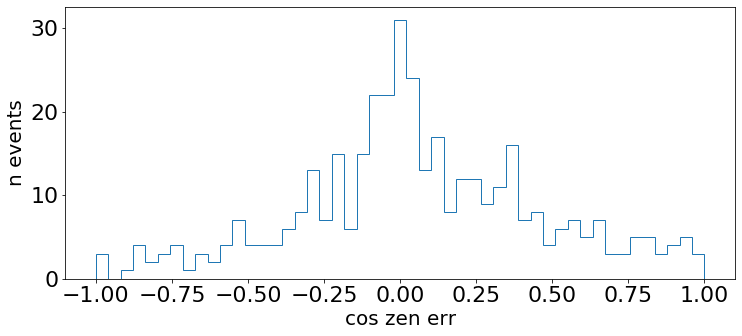

In [25]:
fig, ax = plt.subplots(figsize=(12, 5))
zen_ind = par_names.index('zenith')
true_zen = np.array([event['params'][zen_ind] for event in events])
czen_bins = np.linspace(-1, 1, 50)
ax.hist(np.cos(df.zenith) - np.cos(true_zen), bins=czen_bins, histtype='step')
ax.set_xlabel('cos zen err')
ax.set_ylabel('n events')

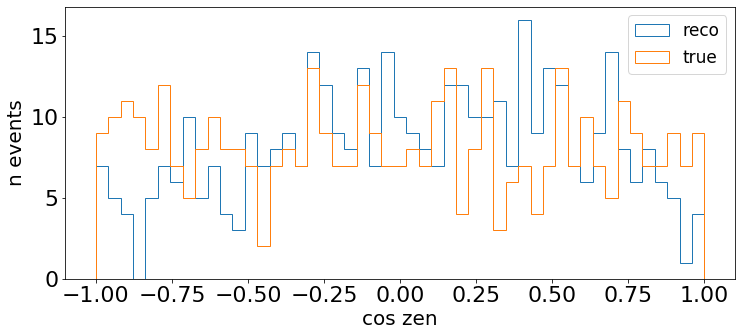

In [26]:
fig, ax = plt.subplots(figsize=(12, 5))
true_zen = np.array([event['params'][zen_ind] for event in events])
bins = np.linspace(-1, 1, 50)
ax.hist(np.cos(df.zenith), bins=bins, histtype='step', label='reco')
ax.hist(np.cos(true_zen), bins=bins, histtype='step', label='true')
ax.set_xlabel('cos zen')
ax.set_ylabel('n events')
ax.legend()